In [1]:
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers import Dense, Dropout, Activation
import keras
from keras import backend as K
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from pandas import DataFrame

/opt/anaconda3/envs/python2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# 设置随机数，是结果可复现
np.random.seed(42)
from tensorflow import set_random_seed
set_random_seed(2)
import os
os.environ['PYTHONHASHSEED'] = '0'
import tensorflow as tf
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, 
                              inter_op_parallelism_threads=1)
tf.set_random_seed(1234)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [3]:
# 设置图片大小
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
# 对取对数的数据还原
def restore_log(num_list):
    for i in range(len(num_list)):
        num_list[i] = np.exp(num_list[i])
    return num_list

# 计算有多少比例的数据误差在per之内
def calc_with_err_per(pre_list_svr,true_list_svr,per=0.2):
    numb=0
    for i in np.arange(len(true_list_svr)):
        errorp=abs(pre_list_svr[i]-true_list_svr[i])/true_list_svr[i]
        if errorp<=per:
            numb=numb+1
        else:
            continue
    Percentageratio=float(numb)/len(true_list_svr)
    return Percentageratio,per

In [6]:
# 导入原始数据，用于还原一阶差分
# 此时数据只进行了累加取log
data = pd.read_csv('data/original_log_3512.csv', parse_dates = True, index_col=0)
data = data[20:]
data.head()

,log_money
data,
2014-01-21,13.956315
2014-01-22,13.849960
2014-01-23,14.364614
2014-01-24,13.654755
2014-01-25,13.946363


测试集为[805:],所以需要的原始数组为[804:],这样对应位置相加就能还原为差分前的数列

In [7]:
before_diff = data.log_money[804:]

In [8]:
# 导入之前清理完成的数据
reframed = pd.read_csv('data/bank_after_clean_20_3512.csv', parse_dates = True, index_col=0)
reframed.head(5)

,count,week_number,weekday,is_quarter_end,holiday,var1(t-20),var1(t-19),var1(t-18),var1(t-17),var1(t-16),...,var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
data,,,,,,,,,,,,,,,,,,,,,
2014-01-21,4,1,0,0,0,13.240680,14.174932,13.816210,13.123762,13.445099,...,13.917480,13.016558,14.140994,13.754114,13.579282,14.122701,13.436736,13.893443,12.917796,13.956315
2014-01-22,4,2,0,0,0,14.174932,13.816210,13.123762,13.445099,13.016558,...,13.016558,14.140994,13.754114,13.579282,14.122701,13.436736,13.893443,12.917796,13.956315,13.849960
2014-01-23,4,3,0,0,0,13.816210,13.123762,13.445099,13.016558,13.956315,...,14.140994,13.754114,13.579282,14.122701,13.436736,13.893443,12.917796,13.956315,13.849960,13.714363
2014-01-24,4,4,0,0,0,13.123762,13.445099,13.016558,13.956315,13.516430,...,13.754114,13.579282,14.122701,13.436736,13.893443,12.917796,13.956315,13.849960,13.714363,13.654755
2014-01-25,4,5,1,0,0,13.445099,13.016558,13.956315,13.516430,14.174932,...,13.579282,14.122701,13.436736,13.893443,12.917796,13.956315,13.849960,13.714363,13.654755,13.946363


In [9]:
reframed = reframed[['count', 'week_number', 'weekday', 'var1(t-14)', 
                     'var1(t-7)','var1(t)']]
# reframed = reframed[10:]

In [10]:
values = reframed.values

In [11]:
test = values[805:, :]
true_y = test[:, -1]

In [12]:
# 选取分割点，划分数据集为训练集和测试集，并把特征转换为3维
def data_split(values,point):
    train = values[:point, :]
    test = values[point:, :]
    train_X, train_y = train[:,:-1], train[:, -1]
    test_X, test_y = test[:,:-1], test[:, -1]
    train_X = train_X.reshape((train_X.shape[0],1,train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0],1,test_X.shape[1]))
#     print(train_X.shape, test_X.shape, train_y.shape, test_y.shape)
    return train_X,train_y,test_X,test_y

In [13]:
# train = values[:805, :]
# test = values[805:, :]
# train_X, train_y = train[:,:-1], train[:, -1]
# test_X, test_y = test[:,:-1], test[:, -1]

In [14]:
# # 转换为3维
# train_X = train_X.reshape((train_X.shape[0],1,train_X.shape[1]))
# test_X = test_X.reshape((test_X.shape[0],1,test_X.shape[1]))

In [15]:
# train_X.shape, test_X.shape, train_y.shape, test_y.shape

In [16]:
# test_X[0].shape

In [17]:
train_X,train_y,test_X,test_y = data_split(values,805)

model = Sequential()
model.add(LSTM(128, input_shape=(train_X.shape[1],train_X.shape[2]),
               activation='relu',return_sequences=False))
# model.add(Dropout(0.5))
model.add(Dense(32,activation='relu',kernel_initializer='random_uniform',
                bias_initializer='zeros'))
# model.add(Dropout(0.5))
# # model.add(LSTM(16,activation='relu',return_sequences=False))
# model.add(Dense(16,kernel_initializer='random_uniform',
#                 bias_initializer='zeros'))
model.add(Dense(1))
opt = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
model.compile(loss='mae',optimizer=opt)

history = model.fit(train_X, train_y, epochs = 50, batch_size=64, 
                validation_data=(test_X, test_y),verbose = 0,shuffle=False)
pre_next = float(model.predict(test_X[0].reshape((1,1,5))))
print(pre_next)

11.8900632858


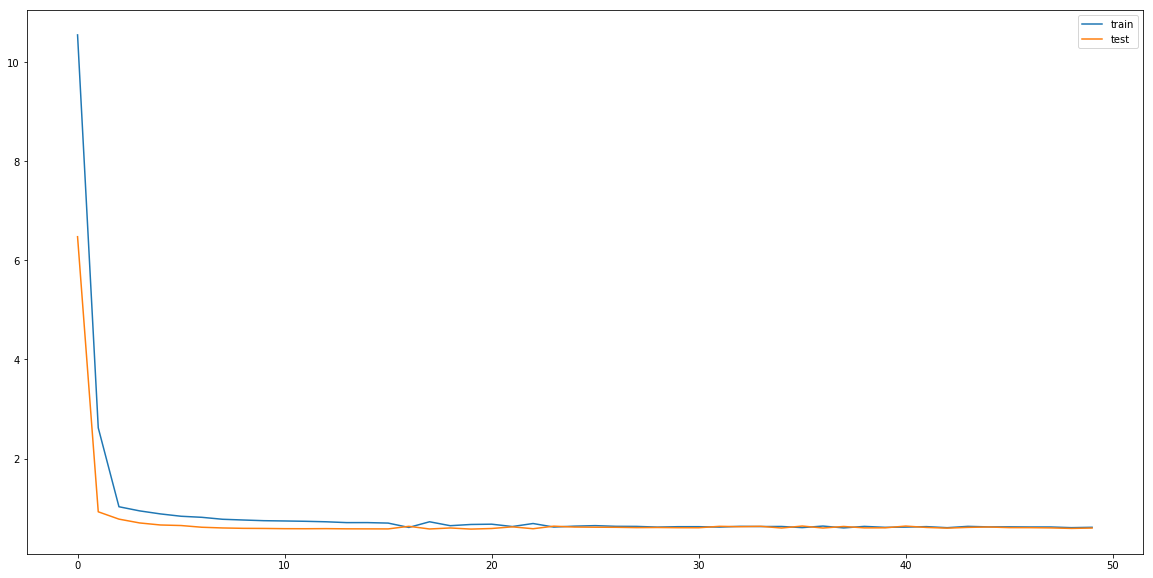

In [18]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [19]:
# 滚动预测
pre_list = []

for i in range(277):
    train_X,train_y,test_X,test_y = data_split(values,805+i)

    model = Sequential()
    model.add(LSTM(128, input_shape=(train_X.shape[1],train_X.shape[2]),
                   activation='relu',return_sequences=False))
    # model.add(Dropout(0.5))
    model.add(Dense(32,activation='relu',kernel_initializer='random_uniform',
                    bias_initializer='zeros'))
    # model.add(Dropout(0.5))
    # # model.add(LSTM(16,activation='relu',return_sequences=False))
    # model.add(Dense(16,kernel_initializer='random_uniform',
    #                 bias_initializer='zeros'))
    model.add(Dense(1))
    opt = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
    model.compile(loss='mae',optimizer=opt)

    history = model.fit(train_X, train_y, epochs = 50, batch_size=64, 
                    validation_data=(test_X, test_y),verbose = 0,shuffle=False)
    pre_next = float(model.predict(test_X[0].reshape((1,1,5))))
    print(pre_next)
    pre_list.append(pre_next)

11.8857841492
13.2674455643
12.7411632538
12.5215854645
11.7946996689
13.4990053177
13.2274475098
11.9806728363
12.5943078995
13.218298912
12.8440313339
11.9401006699
13.5507106781
12.4346208572
12.0818147659
12.2224025726
13.3195867538
12.7175312042
11.948969841
13.5399875641
12.8123884201
12.871254921
12.2012290955
12.1833381653
12.2445106506
12.0185394287
13.6235713959
13.5639619827
14.863442421
13.858455658
12.7797107697
13.1949539185
12.7381744385
14.3988227844
13.5981140137
14.2981777191
12.7253198624
12.6882162094
12.6391296387
12.2535581589
13.6719017029
14.1118984222
12.891787529
11.9535589218
13.3766088486
13.279499054
11.9933433533
12.99401474
13.7028264999
12.1979055405
13.0058059692
13.4703645706
12.7565202713
11.762928009
12.200545311
12.7153615952
12.8276100159
12.6098546982
13.5559720993
12.1410284042
12.0718507767
12.2209224701
12.5179796219
13.7179670334
11.8036594391
13.5394563675
12.1506061554
12.2892370224
12.0621480942
13.3699808121
13.0170593262
12.819478035
13.4

In [20]:
pre_list[:5]

[11.885784149169922,
 13.26744556427002,
 12.74116325378418,
 12.521585464477539,
 11.794699668884277]

In [21]:
# pre_list = pre_list.tolist()
true_list = true_y.tolist()

In [22]:
len(pre_list), len(true_list)

(277, 277)

In [23]:
restore_pre = restore_log(pre_list)

restore_true = restore_log(true_list)

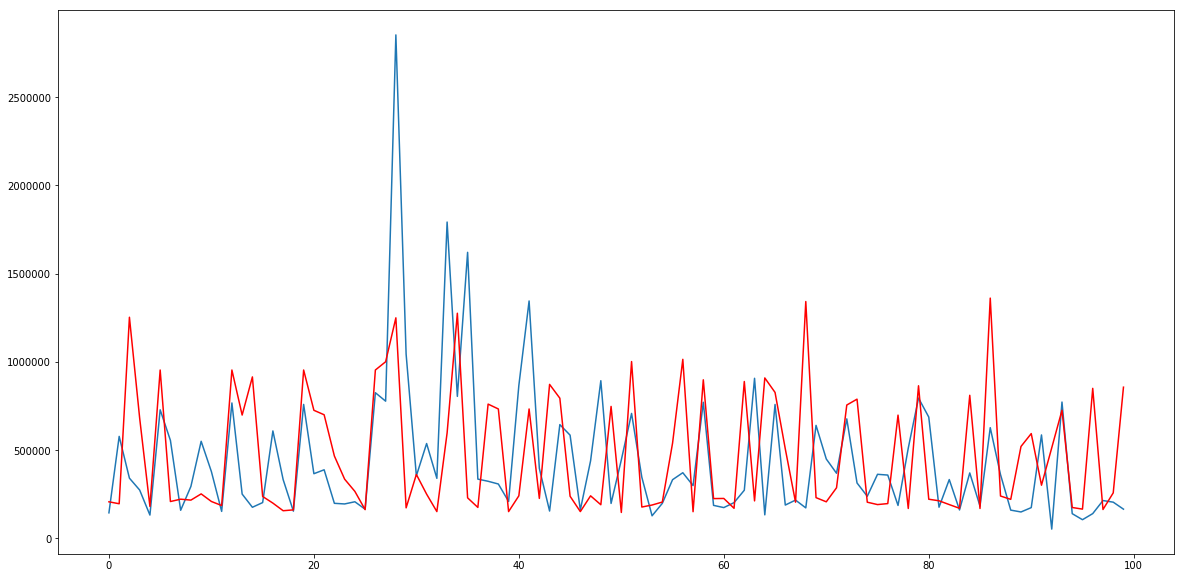

In [24]:
plt.plot(restore_pre[:100])
plt.plot(restore_true[:100], color='red')
plt.show()

In [25]:
# 计算误差
error = sum(list(map(lambda x:abs(abs(x[0] - x[1])/(x[1])), zip(restore_pre,restore_true))))
print('误差：%.2f%%'%float((error/len(restore_true))*100))

误差：68.63%


In [26]:
# 覆盖率计算，预测值大于真实值
count = 0
for i in range(len(restore_pre)):
    if restore_pre[i] > restore_true[i]:
        count += 1
ratio = count*1.0/len(restore_true)
print("覆盖率为：%.2f%%"% (ratio*100))

覆盖率为：46.21%


In [27]:
# 计算有 多少比例 的数据误差在 20.00% 之内
Percentageratio,per = calc_with_err_per(restore_pre,restore_true,0.2)
print('有 %.2f%% 的数据误差在 %.2f%% 之内'% (Percentageratio*100,per*100))

有 24.55% 的数据误差在 20.00% 之内
